# JSMP: Model Development
## Return classification with LightGBM
***

The goal here was to build a multi-category classifier for different return buckets using LightGBM. Instead of a more typical positive vs negative binary approach, I was hoping to also gauge the magnitude and the likelihood of having extreme gains vs extreme losses. The difficulty then lay into transforming these insights into a 0/1 *action* decision and I ended up abandoning this approach. Would be curious to see if anyone chose this approach and made it work! 

Below is just a sample quick training run to give an idea of how this approach worked.

In [1]:
import os
import jsmp
jsmp.env_config("config.json")

Value for DATA_DIR has been set!


## Setup

### File paths

In [2]:
# set competition, training data paths
comp_dir = os.path.join(os.environ.get("DATA_DIR"), "jane-street-market-prediction")
pq_dir = os.path.join(comp_dir, "train") # training data in Parquet format!

### Training configuration

Below I define `train_config`,  which, in addition to typical LightGBM hyperparameters, also includes:
* `'resp_splits'`: the split values to create discrete return bins for classificaiton. Bins the capture returns below -0.033 and above 0.033 are automatically added. 
* `'date_splits'`: implies that 100-380 is the training period, 380-440 the validation period and 440-499 the evaluation period.

In [3]:
train_config = {
    "resp_splits": [-0.033, -0.005, 0, 0.005, 0.033],
    "date_splits": [100, 380, 440], 
    "n_rounds": {'total': 100, 'early': 5},
    "params": {
        "objective": "multiclass",
        "num_class": 6,
        "boosting": "gbdt",
        "eta": 0.05,
        "num_leaves": 30,
        "bagging_freq": 1,
        "bagging_fraction": 0.6,
        "feature_fraction": 0.6,
        "seed": 42
    }
}

## Model training

Here I redeploy the above `train_config` in my custom-made training wrapper function:

In [4]:
lgb_model = jsmp.train_lgb_classifier(pq_dir, train_config, verbose=True)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.033871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32898
[LightGBM] [Info] Number of data points in the train set: 1199059, number of used features: 130
[LightGBM] [Info] Start training from score -2.951425
[LightGBM] [Info] Start training from score -1.418123
[LightGBM] [Info] Start training from score -1.601794
[LightGBM] [Info] Start training from score -1.596770
[LightGBM] [Info] Start training from score -1.404733
[LightGBM] [Info] Start training from score -2.881515
[1]	valid_0's multi_logloss: 1.63397
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 1.62209
[3]	valid_0's multi_logloss: 1.61163
[4]	valid_0's multi_logloss: 1.6025
[5]	valid_0's multi_logloss: 1.59472
[6]	valid_0's multi_logloss: 1.58746
[7]	valid_0's multi_logloss: 1.58054
[8]	valid_0's multi_logloss: 1.57438
[9]	valid_0's multi_loglo

## Predicting return bins

In [5]:
eval_df = jsmp.query_train_pq(pq_dir, date_range=[440, 499], return_cols=['resp', 'weight'])
pred_df = jsmp.gen_return_bins(eval_df, splits=train_config['resp_splits'])
pred_df = jsmp.predict_return_bin(pred_df, lgb_model)
pred_df

,date,ts_id,weight,resp,resp_bin,resp_bin_0,resp_bin_1,resp_bin_2,resp_bin_3,resp_bin_4,resp_bin_5,pred_bin
0,440,2067400,0.000000,-0.017211,1,0.004432,0.262851,0.256753,0.218789,0.252416,0.004759,1
1,440,2067401,0.415759,0.048473,5,0.200129,0.197044,0.062134,0.059465,0.199757,0.281472,5
2,440,2067402,0.051447,0.004821,3,0.003265,0.228017,0.281767,0.250740,0.233298,0.002914,2
3,440,2067403,0.364965,-0.033564,0,0.179626,0.204150,0.070386,0.070463,0.203439,0.271936,5
4,440,2067404,0.330940,0.060841,5,0.040767,0.303182,0.157659,0.156748,0.298673,0.042970,1
...,...,...,...,...,...,...,...,...,...,...,...,...
323086,499,2390486,0.000000,0.015396,4,0.002927,0.146000,0.346678,0.357492,0.144440,0.002464,3
323087,499,2390487,0.000000,-0.004718,2,0.014033,0.244755,0.289918,0.235182,0.195977,0.020135,2
323088,499,2390488,0.000000,0.016591,4,0.006653,0.238419,0.258270,0.249872,0.238599,0.008187,2
323089,499,2390489,0.283405,-0.002004,2,0.004113,0.210423,0.255878,0.292189,0.231897,0.005500,3


### Confusion matrix (percentages)

We can see that the model can learn a systematic ability to predict the correct class more often than random chance. Also, the model appears to be quite strong in classifying **absolute** returns - in other words, it can identify volatility very accurately (even without using `weight` as a feature), but the direction of the return remains a key challenge! 

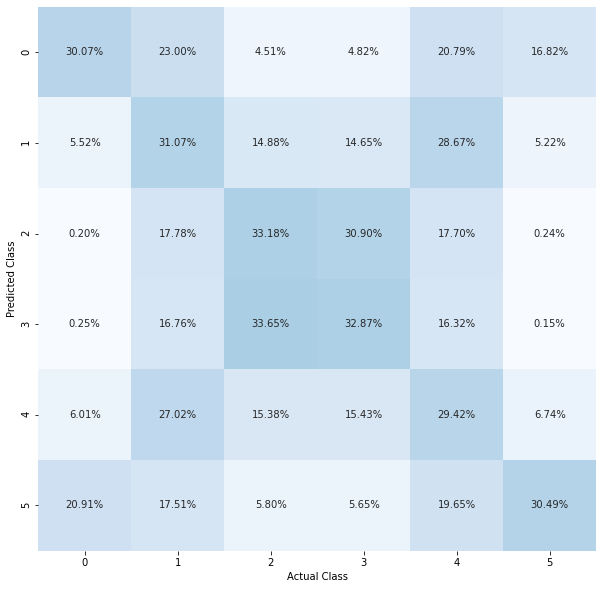

In [6]:
n_bins = train_config['params']['num_class']
jsmp.confusion_matrix(pred_df, n_bins)

### Confusion matrix (counts)

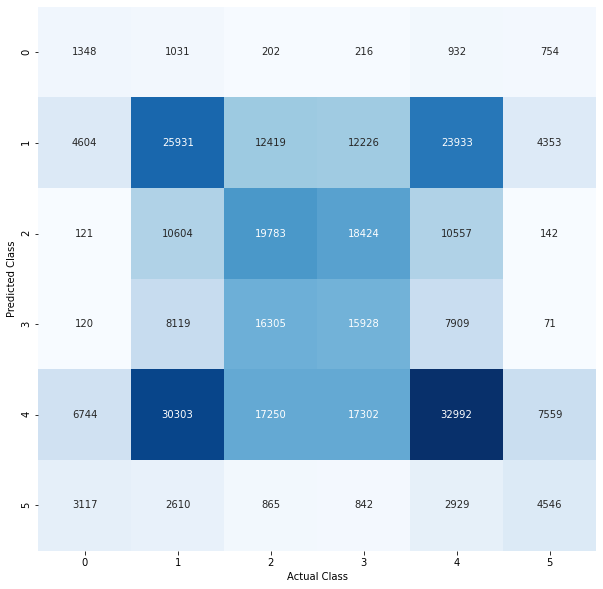

In [7]:
jsmp.confusion_matrix(pred_df, n_bins, as_percent=False)

## Action evaluation

### Naive rule

Given the model appears to perform better at the extreme ends, I ignored the median 2 bins and compared the sum of probabilities in the 2 lowest and 2 highest return bins to determine the optimal action:

Profit: 279.41 | Volatility: 68.42 | Sharpe Ratio: 4.08 | Utility: 1141.09


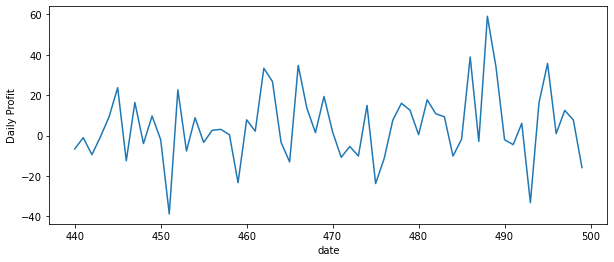

In [8]:
good_bins = ["resp_bin_" + str(i) for i in range(n_bins) if i > (n_bins/2)]
bad_bins = ["resp_bin_" + str(i) for i in range(n_bins) if i < (n_bins/2 - 1)]
pred_df.loc[:, "action"] = (pred_df[good_bins].sum(axis=1) > 
                            pred_df[bad_bins].sum(axis=1)).astype(int)
u, profit = jsmp.compute_utility(pred_df, verbose=True)

### Avoiding large weights

I also found that large weights made a big impact on the final utility. My takeway was that if you can't predict well for trades with large weights, just ignore them and your score will increase! Also, larger weights are associated with lower volatility and that's where the model struggled to consistently predict the direction of returns.

Profit: 349.34 | Volatility: 65.98 | Sharpe Ratio: 5.29 | Utility: 1849.56


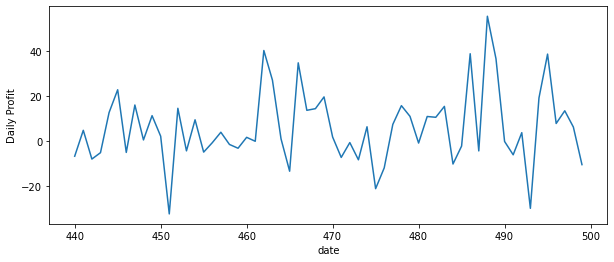

In [9]:
pred_df.loc[(pred_df['weight'] > 40), "action"] = 0
u, profit = jsmp.compute_utility(pred_df, verbose=True)

## Conclusion

* It was challenging to systematically come up with an optimal action function given a set of return class probabilities
* Ultimately, I felt that a building a model that directly predicted the action would work best and that's when I started experimenting with Neural Networks